In [1]:
%%time
import sys;
!{sys.executable} -m pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 41.8 ms, sys: 19.3 ms, total: 61.1 ms
Wall time: 2.24 s


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 793 ms, sys: 67.1 ms, total: 860 ms
Wall time: 2.89 s


In [3]:
%%time
import random
import pandas as pd
raw_data_filename = 'frauddetection.csv'

s3 = boto3.resource('s3', region_name=region)
s3.Bucket(bucket).download_file('frauddetection/'+raw_data_filename, raw_data_filename)
percent_to_read = 1
fraction_to_read=percent_to_read/100 # 
df = pd.read_csv('./'+raw_data_filename,  skiprows=lambda i: i>0 and random.random() > fraction_to_read)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print('Length', len(df))
target_col='isFraud'
df

Length 63714
CPU times: user 11 s, sys: 2.76 s, total: 13.8 s
Wall time: 13.8 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_OUT,71991.42,C990679445,0.00,0.00,C557041912,81682.58,557537.26,0,0
1,1,PAYMENT,9374.72,C95685867,21064.00,11689.28,M331596257,0.00,0.00,0,0
2,1,DEBIT,4040.84,C1800693087,1938.00,0.00,C1825027294,51339.00,36757.68,0,0
3,1,CASH_OUT,156819.60,C503595296,0.00,0.00,C1318822808,438635.96,500631.71,0,0
4,1,PAYMENT,1383.56,C1818449913,5309.00,3925.44,M1495161082,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
63709,718,CASH_OUT,200834.69,C1560700258,19919.00,0.00,C1585598736,780138.49,980973.17,0,0
63710,718,PAYMENT,6038.63,C228082430,9562.00,3523.37,M1327324536,0.00,0.00,0,0
63711,718,TRANSFER,8851.38,C1268545631,8851.38,0.00,C1588541391,0.00,0.00,1,0
63712,729,CASH_OUT,90026.90,C157425928,90026.90,0.00,C1303144727,339171.02,429197.92,1,0


All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never but `CASH_IN` or `PAYMENT`. Could filter these out.

Counts of each class to determine imbalance.

In [4]:
 
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 75 ; Not fraud 63639 ; Total 63714


Not using `isFlaggedFraud`.

In [5]:
df = df.drop(['isFlaggedFraud'], axis=1)

Plot distribution of positive vs negative, in log scale because of the imbalance

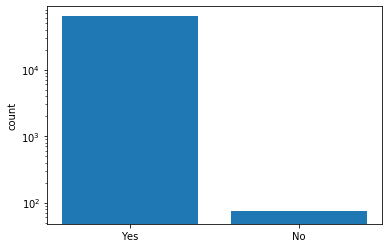

In [6]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
    val_counts=df[target_col].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale="log")
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,target_col)

Scale the numerical values.

In [7]:
#Split numerical from non-numerical
columns = df.columns
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
other_col =[c for c in columns if  c not in numerical_cols]
df_other = df[other_col]

df_num = df[numerical_cols]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
df = pd.concat([df_num, df_other], axis=1)
df = df[columns] # Put back in old order
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,CASH_OUT,-0.181606,C990679445,-0.290023,-0.293911,C557041912,-0.277444,-0.169476,0
1,1,PAYMENT,-0.289053,C95685867,-0.282422,-0.289748,M331596257,-0.299470,-0.309664,0
2,1,DEBIT,-0.298205,C1800693087,-0.289323,-0.293911,C1825027294,-0.285626,-0.300422,0
3,1,CASH_OUT,-0.036046,C503595296,-0.290023,-0.293911,C1318822808,-0.181188,-0.183785,0
4,1,PAYMENT,-0.302765,C1818449913,-0.288107,-0.292513,M1495161082,-0.299470,-0.309664,0
...,...,...,...,...,...,...,...,...,...,...
63709,718,CASH_OUT,0.039481,C1560700258,-0.282835,-0.293911,C1585598736,-0.089098,-0.063007,0
63710,718,PAYMENT,-0.294777,C228082430,-0.286572,-0.292656,M1327324536,-0.299470,-0.309664,0
63711,718,TRANSFER,-0.289951,C1268545631,-0.286829,-0.293911,C1588541391,-0.299470,-0.309664,1
63712,729,CASH_OUT,-0.150658,C157425928,-0.257536,-0.293911,C1303144727,-0.208009,-0.201746,1


Make dummies (onehot) for `type` field.

In [8]:
cols = df.columns.tolist()
cols.remove(target_col)
cols = [target_col] + cols
df = df[cols] # Move target to the left

df_dummies=pd.get_dummies(df['type'],drop_first=True )

df=df.drop(['type'], axis=1)
df = pd.concat([df, df_dummies], axis=1)
 

We could use *HashingEncoder* to handle categorical columns with high cardinality. These cannot be onehotted as that would generate too many columns and a too-sparse matrix. However, this seems to provide no accuracy benefit.

In [9]:
%%time
high_cardinality__categorical_col = ['nameOrig', 'nameDest']
use_hashing_encoder = False
if not use_hashing_encoder:
    print('Dropping high-cardinality categorical columns')
    df=df.drop(high_cardinality__categorical_col, axis=1)
else:
  import category_encoders as ce  
  columns_before = [x for x in df.columns if x not in high_cardinality__categorical_col+[target_col]]

  def make_col_mapping(cols):
    col_mapping = {}
    for c in cols:
        if c[:4]=='col_':
          num = c.split('_')[-1]
          int(num) # check format
          col_mapping[c] = hashencode_this + "_" + num
     
    return col_mapping

  
  def hashencode(hashencode_this, df, previous_hash_cols):
    """Could hashencode both columns, but for now hashencode does not seem to provide a benefit."""
    for c in df.columns:
        assert c[:4]!="col_",  df.columns
    cpus_in_t2xlarge = 4
    default_max_sample = len(df)/cpus_in_t2xlarge
    max_sample = default_max_sample/2
    ce_hash = ce.HashingEncoder(cols = [hashencode_this],max_sample=max_sample)
    X1 = df.drop([target_col], axis=1)
    y1 = df[target_col]
    with_hashing = ce_hash.fit_transform(X1, y1)
    hashed = with_hashing.drop(columns_before+previous_hash_cols, axis=1)
    generated_cols = [x for x in hashed.columns if x[:4]=='col_']
    col_mapping = make_col_mapping(generated_cols)
    
    hashed = hashed.rename(columns = col_mapping)
    df = pd.concat([y1, X1, hashed], axis=1)
 
    df = df.drop([hashencode_this], axis=1)
    return df, list(col_mapping.values())
 
  previous_hash_cols = []
  for hashencode_this in high_cardinality__categorical_col: 
   df, previous_hash_cols = hashencode(hashencode_this,df,previous_hash_cols)
 

Dropping high-cardinality categorical columns
CPU times: user 9.04 ms, sys: 0 ns, total: 9.04 ms
Wall time: 7.57 ms


Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost parameters.

In [10]:

from imblearn.over_sampling import SMOTENC
# Using weighting in XGBOOST instead of SMOTENC
use_smote = False
if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

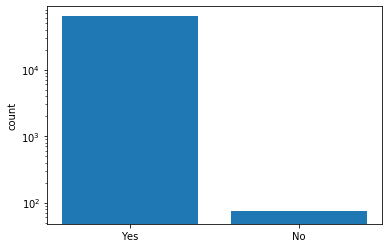

In [11]:
plot_positive_negative_counts(df,target_col)

# Split  with randomization

In [12]:
import numpy as np
len_=len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

Using libSVM for performance.

In [13]:
%%time
from sklearn.datasets import dump_svmlight_file   

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

s3 = boto3.resource('s3', region_name=region)#TODO Remove

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

Length of datasets: [('train', 44599), ('validation', 12743), ('test', 6372)]
CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 2.93 s


In [14]:
def s3_path(subset):
  return sagemaker.TrainingInput(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

---
## Train

Our data is now ready to be used to train a XGBoost model. The XGBoost algorithm has many tunable hyperparameters. Some of these hyperparameters are listed below; initially we'll only use a few of them.  

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.  The Estimator object from the Amazon SageMaker Python SDK is a convenient way to set up training jobs with a minimal amount of code.

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)

num_positive, num_negative=count_positive_and_negative(train_data)
scale_pos_weight= 1 if not num_positive else num_negative / num_positive  

print(f'num_positive: {num_positive}, num_negative: {num_negative}, scale_pos_weight {scale_pos_weight:.1f}')

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=100)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


num_positive: 54, num_negative: 44545, scale_pos_weight 824.9


Run the hosted training (`fit`) job.

In [16]:
%%time
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-11-26 18:27:11 Starting - Starting the training job...
2020-11-26 18:27:13 Starting - Launching requested ML instances......
2020-11-26 18:28:35 Starting - Preparing the instances for training......
2020-11-26 18:29:25 Downloading - Downloading input data
2020-11-26 18:29:25 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[18:29:47] 44599x10 matrix with 302419 entries loaded from /opt/ml/input/data/train
[18:29:47] 12743x10 matrix with 86392 entries loaded from /opt/ml/input/data/validation
INFO:root:Single node t

---
## Host

Now that we've trained the XGBoost algorithm on our data, we can deploy the trained model to an Amazon SageMaker hosted endpoint with one simple line of code.

In [37]:
import datetime 
import time
model = xgb.create_model()
container_def = model.prepare_container_def(instance_type='ml.m4.xlarge')
model_name = 'fraud-' + datetime.datetime.now().isoformat().replace('.','-').replace(':','-')[:-7] +'Z' 
print('model_name', model_name)
 
endpoint_name = 'fraud-detection-endpoint'
 
def deploy_on_new_endpoint():
      print('deploy_on_new_endpoint')
      ret = xgb.deploy(endpoint_name=endpoint_name, model_name=model_name,
                                 initial_instance_count=1, instance_type='ml.m5.xlarge', accelerator_type='ml.eia2.medium')
      print(1,'ret', ret)
      return ret
    
def deploy_on_existing_endpoint():
        print('deploy_on_existing_endpoint')
        session.create_model(model_name, role, container_def)
        
        endpoint_config_name = session.create_endpoint_config(name=model_name,
                                                      model_name=model_name,
                                                      initial_instance_count=1,
                                                      instance_type='ml.m5.xlarge',
                                                      accelerator_type='ml.eia2.medium')
        
        client = boto3.client('sagemaker')
        updated_endpoint=client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        print(updated_endpoint)
        ret = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sagemaker.Session())
        print(2,'ret', ret)
        return ret
print(0)
retry = True
while retry:
  try:
 
     xgb_predictor= deploy_on_existing_endpoint()
     retry = False
  except Exception as e:
      print("Exception", e)
      if 'Cannot update in-progress endpoint' in str(e):
        time.sleep(30)
        retry = True
        continue
      elif 'Could not find endpoint' in str(e):
         xgb_predictor= deploy_on_new_endpoint()
         retry = False
      
print(xgb_predictor)

model_name fraud-2020-11-26T18-47-47Z
0
deploy_on_existing_endpoint
1
2
An error occurred (ValidationException) when calling the UpdateEndpoint operation: Cannot update in-progress endpoint "arn:aws:sagemaker:eu-west-1:649592902942:endpoint/fraud-detection-endpoint".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


Using already existing model: fraud-2020-11-26T18-47-47Z


1
An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:eu-west-1:649592902942:endpoint-config/fraud-2020-11-26t18-47-47z".
deploy_on_existing_endpoint


KeyboardInterrupt: 

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [22]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

AttributeError: 'NoneType' object has no attribute 'content_type'

In [ ]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

In [ ]:

actual_pos = sum(1 for i in range(len(labels)) if 1==labels[i])
actual_neg = sum(1 for i in range(len(labels)) if 0==labels[i])

pred_pos = sum(1 for i in range(len(preds)) if 1==preds[i])
pred_neg = sum(1 for i in range(len(preds)) if 0==preds[i])

true_pos = sum(1 for i in range(len(preds)) if preds[i]==1==labels[i])
true_neg = sum(1 for i in range(len(preds)) if preds[i]==0==labels[i])

false_pos=sum(1 for i in range(len(preds)) if preds[i]==1 and 0==labels[i])
false_neg=sum(1 for i in range(len(preds)) if preds[i]==0 and 1==labels[i])

recall = true_pos/(true_pos+false_neg)
precision = true_pos/(true_pos+false_pos)
f1 = (2 * precision * recall) / (precision + recall)
error = sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))
assert recall <= f1 <= precision or precision <= f1 <= recall 
assert true_pos + false_neg == actual_pos
assert true_neg + false_pos == actual_neg
#print('pred_pos', pred_pos,'pred_neg', pred_neg)

assert len(preds)==len(labels)

#print(len(preds), 'predictions and labels')

#print('actual_pos', actual_pos, 'actual_neg', actual_neg)
assert actual_pos+actual_neg==len(labels)
                   
#print('true_pos', true_pos, 'false_pos', false_pos)
#assert  true_pos+false_pos == pred_pos

#print('true_neg', true_neg, 'false_neg', false_neg )
assert true_neg+false_neg== pred_neg

#print('pred_pos+pred_neg',pred_pos+pred_neg)
assert pred_pos+pred_neg==len(preds)

print(f'Recall={recall:.2f}')
print(f'Precision={precision:.2f}')
print(f'Error rate={error:.2f}')
print(f'F1={f1:.2f}')

Show confusion matrix.

In [ ]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

Clean up to save money

In [ ]:
#session.delete_endpoint(xgb_predictor.endpoint)